# BSEP 

## Import Libraries

By importing the file/function using import, Python modules can get access to the code from another module.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors
from rdkit.Chem import PandasTools as PandasTools
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from standardise import Standardization

## Step 1: Data Upload & Data Addition

In this section data provided by the University of Vienna can be combined with own in-house data. The addition of new compounds allows the creation of a new training set that can be used for the retraining of the Machine Learning (ML) models within this Jupyter Notebook (JN). 

!!! If you don’t want to add additional data, you can skip this step!!!

### UNIVIE Data*

UNIVIE data refers to collected, curated data that has been provided by the University of Vienna for the purpose of training/retraining ML models for six different endpoints:

    • BCRP
    • BSEP
    • OATP1B1
    • OATP1B3
    • MRP3
    • P-gp

Datasets that will be used within this JN such as the training set and the test set must be saved within the folder /data.

You can select the dataset for the endpoint by changing the file name at the variable “UNIVIE_Data”: e.g.: "data/BSEP_Univie.sdf" --> "data/BCRP_Univie.sdf"

In [2]:
# Please add the name of the UNIVIE file
Univie_Data = "data/BSEP_Univie.sdf"

### Intern Data*

You can include your own in-house dataset for the previous selected endpoint by changing the file name at the variable “Intern_Data” to the name of your dataset.



Keep in mind that the path to your dataset has to be properly defined. 

In [3]:
# Please add the name of your file
Intern_Data = "data/BSEP_ChEMBL28.sdf"

### Load SDF File

The SDF-files are loaded into the JN as dataframes which allow better representation of the information contained within the SDF-files. 

In [4]:
df_Univie_Data = PandasTools.LoadSDF(Univie_Data)
df_Intern_Data = PandasTools.LoadSDF(Intern_Data)

### InChIs, SMILES & InChIkey Calculation

To provide additional information about the molecules, the InChIs, SMILES, and InChIkeys are calculated.

In [7]:
df_Intern_Data['InChIs'] = df_Intern_Data['ROMol'].map(lambda x:AllChem.MolToInchi(x))
df_Intern_Data['SMILES'] = df_Intern_Data['ROMol'].map(lambda x:AllChem.MolToSmiles(x))
df_Intern_Data['InChIKey'] = df_Intern_Data['ROMol'].map(lambda x:AllChem.MolToInchiKey(x))

### Remove Stereochemistry

Stereochemistry is removed based on the previously calculated InChIs. This step is performed prior duplicate check.

In [6]:
ls_InChIs = df_Intern_Data['InChIs'].tolist()

In [7]:
def removeStereo(fullInchi, position, delimiter):
    return delimiter.join(fullInchi.split(delimiter)[:position])

ls_Curated_InChIs = []

for i in ls_InChIs:
    ls_noniso = (removeStereo(i,4,"/"))
    ls_Curated_InChIs.append(ls_noniso)
    
df_Intern_Data['Curated_InChIs'] = ls_Curated_InChIs

### Duplicate Check

The duplicates are removed based on the InChIs.

In [8]:
Intern_Unique = df_Intern_Data.drop_duplicates(subset='Curated_InChIs',keep='first')
Intern_Duplicates = df_Intern_Data[df_Intern_Data.duplicated(['Curated_InChIs'], keep='first')]

### Comparison of Classification Values of Removed Duplicates

Classification values of duplicates are compared after the duplicate check and compounds with different values are excluded.

In [9]:
def remove_classerror(x):
        if x in df_classerror:
            df_classerror.remove(x)
            return False
        return True

if len(Intern_Duplicates.index) == 0:
    print('No duplicates found.')
else:
    Comparison_dupl = Intern_Duplicates[['ROMol','Classification','Curated_InChIs']]
    Comparison_uniq = Intern_Unique[['ROMol','Classification','Curated_InChIs']]
    merged   =    pd.merge(
                  left=Comparison_dupl,
                  right=Comparison_uniq,
                  how="left",
                  left_on="Curated_InChIs",
                  right_on="Curated_InChIs")
    merged['Class_Match'] = merged.apply(lambda x : str(x.Classification_x) in str(x.Classification_y), axis=1)
    Non_Matching_Class = merged.loc[merged['Class_Match'] == False]
    df_classerror = Non_Matching_Class['Curated_InChIs'].tolist()
    Intern_Unique = Intern_Unique[Intern_Unique.Curated_InChIs.apply(remove_classerror)]
    print('Compounds with classification mismatch removed.')

No duplicates found.


### Duplicate Removal

InChIs from the UNIVIE dataset and the Intern dataset are compared with each other and duplicates are removed.

In [ ]:
def remove_duplicates(x):
    if x in ls_Univie_Transporters:
        ls_Univie_Transporters.remove(x)
        return False
    return True

ls_Univie_Transporters = df_Univie_Data['Curated_InChIs'].tolist()


Delta_Compounds = Intern_Unique[Intern_Unique.Curated_InChIs.apply(remove_duplicates)]
Delta_Compounds.info()

### Selection of Important Columns

The columns: Classification, ROMol, InChI, SMILES and InChIKey are kept.

In [ ]:
Columns_Univie =  df_Univie_Data[['Classification', 'ROMol', 'Curated_InChIs','SMILES','InChIKey']]
Columns_Intern = Delta_Compounds[['Classification', 'ROMol', 'Curated_InChIs','SMILES','InChIKey']]
Training_Set = pd.concat([Columns_Univie, Columns_Intern], sort=False)

### Save Generated Training Set

A SDF-file is generated namely:” Training_Set.sdf” which includes a new training set with the above mentioned columns.

In [ ]:
PandasTools.WriteSDF(Training_Set,"data/BSEP_Training_Set.sdf",properties=list(Training_Set.columns))

## Step 2: Data Set Preparation for ML Task

### Read SDF

#### Training set*

The training set is uploaded into the JN at the variable "molecules" via the RDKit functionality for working with molecular file format.

You can select the training set for the endpoint by changing the file name at the variable "molecules".

In [4]:
# Please add the name of your training set
molecules = Chem.ForwardSDMolSupplier("data/BSEP_Univie.sdf", sanitize=False)

#### Test set*

The test set is uploaded into the JN at the variable "test_molecules" via the RDKit functionality for working with molecular file format.

You can select the test set for the endpoint by changing the file name at the variable "test_molecules".

In [5]:
# Please add the name of your test set
test_molecules = Chem.ForwardSDMolSupplier("data/BSEP_ChEMBL28.sdf", sanitize=False)

### Standardisation

#### Training set

Compounds within the training set are standardised using a modified atkinson standardizer. 

In [6]:
stand = Standardization()

train_molcount = 0

standardised_molecules = []
            
for mol in molecules:
        train_molcount += 1

        if mol is None:
            continue

        standardisation_ok, molOrError = stand.standardise(mol)
        
        if standardisation_ok == True:
            standardised_molecules.append(molOrError)
        else:
            print(molOrError)

RDKit WARNING: [17:42:47] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [17:42:47] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [17:42:47] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [17:42:47] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [17:42:47] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [17:42:47] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [17:42:47] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [17:42:47] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [17:42:47] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [17:42:47] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [17:42:47] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [17:42:47] Warning: molecule

A standardised training set dataframe is created that can be saved as a SDF-file.

In [ ]:
df_standardised_train_molecules = pd.DataFrame(standardised_molecules)
df_standardised_train_molecules.rename(columns = {0:'ROMol'}, inplace = True)

A SDF-file is generated namely:” standardised_train_molecules.sdf” which includes the standardised training set.

In [ ]:
PandasTools.WriteSDF(df_standardised_train_molecules,"data/BSEP_standardised_train_molecules.sdf",properties=list(df_standardised_train_molecules.columns))

#### Test set

Compounds within the test set are standardised using a modified atkinson standardizer. 

In [7]:
stand = Standardization()

test_molcount = 0

standardised_test_molecules = []

for mol in test_molecules:
        test_molcount += 1
        
        if mol is None:
            continue
            
        standardisation_ok, molOrError = stand.standardise(mol)
        
        if standardisation_ok == True:
            standardised_test_molecules.append(molOrError)
        else:
            print(molOrError)

A standardised test set dataframe is created that can be saved as a SDF-file.

In [8]:
df_standardised_test_molecules = pd.DataFrame(standardised_test_molecules)
df_standardised_test_molecules.rename(columns = {0:'ROMol'}, inplace = True)

A SDF-file is generated namely:” standardised_test_molecules.sdf” which includes the standardised test set.

This standardised test set is later used for the applicability domain (AD). 

In [108]:
PandasTools.WriteSDF(df_standardised_test_molecules,"data/BSEP_standardised_test_molecules.sdf",properties=list(df_standardised_test_molecules.columns))

### Check Standardisation

The number of compounds within the training set that were able to be standardised is displayed.

In [10]:
print (str(len(standardised_molecules)) + ' of ' + str(train_molcount) + ' compounds could be standardised.')

1321 of 1321 compounds could be standardised.


The number of compounds within the test set that were able to be standardised is displayed.

In [11]:
print (str(len(standardised_test_molecules)) + ' of ' + str(test_molcount) + ' compounds could be standardised.')

10 of 10 compounds could be standardised.


### Check Descriptors

In [12]:
from rdkit.ML.Descriptors import MoleculeDescriptors
import numpy as np

The 70 predefined RDKit descriptors are available in the file "RDKIT_Descriptors.txt".

These descriptors have been found to be important for describing the six enpdoints.

In [13]:
with open("RDKIT_Descriptors.txt", "r") as f:
    Descriptors = []
    for descriptor in f.readlines():
        items = descriptor.rstrip('\n').rstrip(',').strip("''")
        Descriptors.append(items)

Checks if the 70 descriptors are used and the number of descriptors used is displayed.

In [14]:
print (str(len(Descriptors)) + ' descriptors are used.')

70 descriptors are used.


#### Training set

70 descriptors are calculated for each compound within the standardised training set. 

The results and the classification values are saved as a list.

In [15]:
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(Descriptors)
descriptors = []
activities = []

for mol in standardised_molecules:

    desc_np = np.asarray(calculator.CalcDescriptors(mol))

    descriptors.append(desc_np)

    activities.append(int(mol.GetProp("Classification")))

#### Test set 

70 descriptors are calculated for each compound within the standardised test set. 

The results and the classification values are saved as a list.

In [16]:
calculator_test = MoleculeDescriptors.MolecularDescriptorCalculator(Descriptors)
descriptors_test = []
activities_test = []

for mol in standardised_test_molecules:
    desc_np = np.asarray(calculator_test.CalcDescriptors(mol))
    descriptors_test.append(desc_np)
    activities_test.append(int(mol.GetProp("Classification")))

### Check Descriptor Calculation

#### Training set

The results of the descriptor calculation and the classification values are displayed for the standardised training set.

In [17]:
print('The descriptors for ' + str(len(descriptors)) + ' compounds could be calculated.')
print('The activities of ' + str(len(activities)) + ' compounds could be read.') 

The descriptors for 1321 compounds could be calculated.
The activities of 1321 compounds could be read.


#### Test set

The results of the descriptor calculation and the classification values are displayed for the standardised test set.

In [18]:
print('The descriptors for ' + str(len(descriptors_test)) + ' compounds could be calculated.')
print('The activities of ' + str(len(activities_test)) + ' compounds could be read.')

The descriptors for 10 compounds could be calculated.
The activities of 10 compounds could be read.


### Count actives / inactives

#### Training set

The number of inhibitors, non-inhibitors as well as the total amount of compounds within the standardised training set are displayed.

In [19]:
active = 0
inactive = 0
for activity in activities:
    if activity == 1:
        active += 1
    elif activity == 0:
        inactive += 1
print('The training set includes', active, 'inhibitors and', inactive, 'non-inhibitors.')
print('The total amount of compounds in the training set is', active + inactive, '.')

The training set includes 221 inhibitors and 1100 non-inhibitors.
The total amount of compounds in the training set is 1321 .


#### Test set 

The number of inhibitors, non-inhibitors as well as the total amount of compounds within the standardised test set are displayed.

In [20]:
active_test = 0
inactive_test = 0
for activity_test in activities_test:
    if activity_test == 1:
        active_test += 1
    elif activity_test == 0:
        inactive_test += 1
print('The training set includes', active_test, 'inhibitors and', inactive_test, 'non-inhibitors.')
print('The total amount of compounds in the training set is', active_test + inactive_test, '.')

The training set includes 3 inhibitors and 7 non-inhibitors.
The total amount of compounds in the training set is 10 .


#### Change NaN to 0.0

NaN values are replaced with zeros for avoiding potential errors.

In [21]:
df_descriptors = pd.DataFrame(descriptors)
zeros = df_descriptors.fillna(0.0)
descriptors = np.array(zeros)
descriptors.shape

(1321, 70)

## Step 3: Applicability Domain

Local outlier factor (LOF) as described by Sahigara and coworkers is used for the calculation of the applicability domain (Sahigara F, Ballabio D, Todeschini R, Consonni V (2013) Defining a novel k-nearest neighbours approach to assess the applicability domain of a QSAR model for reliable predictions. J Cheminform 5:27. https://doi.org/10.1186/1758-2946-5-27) and was implemented in the scikit-learn Python library (version 0.24.2). 

In this approach the local densities of the nearest neighbors of a compound are compared to its local densities, and a factor from 0 to 1 is assigned. In brief, if the local density is greater or equal to its surrounding, a compound is considered inside the domain, otherwise it is considered outside the domain. 

In [22]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Verify that the test set is within the chemical space of the model*

You can select the test set for the AD by changing the file name at the variable “Test_Data". 

In [23]:
Test_Data = "data/BSEP_ChEMBL28.sdf"

The AD is calculated and displayed as a depiction for a general representation if the test set is inside or outside of the AD. 

Red line = Applicability domain

White dots = Test set compounds

Blue colour = Frontier-delimited subspace

Text(0.5, 0, 'PCA Dimension 0')

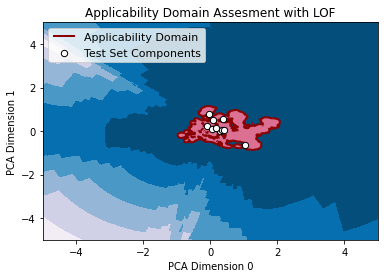

In [24]:
scaler = MinMaxScaler()
iso_map = PCA(n_components=2)
model = LocalOutlierFactor(n_neighbors=5, novelty=True, contamination=0.1, metric='euclidean')

fps = []
thresholds = []
k = 15
stand = Standardization()

scaler.fit(descriptors)
stand_desc = scaler.transform(descriptors)
iso_map.fit(stand_desc)
train_iso = iso_map.transform(stand_desc)
model.fit(train_iso)

tests = []
test_stand_desc = scaler.transform(descriptors_test)
test_iso = iso_map.transform(test_stand_desc)
#tests.append([test_iso[0][0], test_iso[0][1]])
iso_ad_pred = []
for tp in test_iso:
    iso_ad_pred.append(model.predict([tp])[0])
    tests.append([tp[0], tp[1]])


tests = np.array(tests)
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure()
plt.title("Applicability Domain Assessment with LOF")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
s = 40
b2 = plt.scatter(tests[:, 0], tests[:, 1], c='white', s=s,edgecolors='k', zorder=3)
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0],b2],
  ["Applicability Domain",
   "Test Set Components"],
  loc="upper left",
  prop=matplotlib.font_manager.FontProperties(size=11))
plt.ylabel("PCA Dimension 1")
plt.xlabel("PCA Dimension 0")

The test set is checked if it is within the chemical space of the model and an additional column named "LOF" is created containing "1" for inlier and "-1" for outlier.

1 compounds have been identified as outliers in the Test Set using LOF.



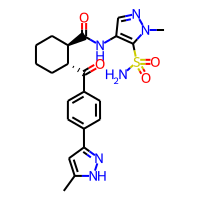

In [25]:
from IPython.core.display import display, HTML

# if lof equal to 1, then it is considered as an inlier; if it is -1, then it is an outlier.
df_descriptors_test = pd.DataFrame(descriptors_test, columns = Descriptors)
df_descriptors_test['LOF'] = iso_ad_pred
Test_Outliers = df_descriptors_test[df_descriptors_test['LOF'] == -1]
New_Descriptors_test = df_descriptors_test[df_descriptors_test['LOF'] == 1]

# Read data
df_Test_Data = PandasTools.LoadSDF(Test_Data)

# Search via index outliers 
Outlier_Compounds = df_Test_Data['ROMol'].loc[Test_Outliers.index]
df_Outlier_Compounds = pd.DataFrame(Outlier_Compounds)
print(str(len(Test_Outliers)) + ' compounds have been identified as outliers in the Test Set using LOF.')

for index, row in df_Outlier_Compounds.iterrows():
    display(HTML(str(row['ROMol'])))

 A SDF-file is generated namely:” Outlier_Compounds.sdf” which includes all compounds that are out of domain.

In [ ]:
PandasTools.WriteSDF(df_Outlier_Compounds,"results/BSEP_Outlier_Compounds.sdf",properties=list(df_Outlier_Compounds.columns))

## Step 4: Model Generation & Evaluation

Four different classifiers are used for model generation:

    • Logistic Regression (LR)
    • Support Vector Machine (SVM)
    • Random Forest (RF)
    • k-nearest neighbor (KNN)

The scikit-learn Python library (version 0.24.2) implementations are used to train binary classification models for the six mentioned endpoints.

### Please add the name of the used training set*

You can select the dataset for the creation of the ML models by changing the file name at the variable “Train_Stand_SDF”.

In [3]:
Train_Stand_SDF = "data/BSEP_standardised_train_molecules.sdf"
df_Data = PandasTools.LoadSDF(Train_Stand_SDF)

### Please add the name of the used test set*

You can select the dataset for testing the ML models by changing the file name at the variable “Test_Stand_SDF”.

In [2]:
Test_Stand_SDF = "data/BSEP_standardised_test_molecules.sdf"
df_Test_Data = PandasTools.LoadSDF(Test_Stand_SDF)

### 1) Logisitic Regression (LR)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

A LR model is created with pre-selected hyperparameters and fitted on the training set.

In [29]:
lr_clf = LogisticRegression(solver='saga', max_iter=10000)
lr_clf.fit(descriptors,activities)

LogisticRegression(max_iter=10000, solver='saga')

A pickle-file is generated namely:” model_LR.pkl” which includes the model. 

Pickle in Python is used in serializing and deserializing a Python object structure.

In [ ]:
import pickle

filename = 'results/BSEP_model_LR.pkl'
pickle.dump(lr_clf, open(filename, 'wb'))

#### LR -  10-CV Training Set

In [39]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

The performance of the models is evaluated using a 10-fold cross-validation, and following statistical metrics are used:

    • Accuracy Score
    • Sensitivity Score
    • Specificity Score
    • Balanced Accuracy (BA) Score
    • F1 Score
    • Area Under the Curve (AUC) Score
    • Precision Score
    • Matthews Correlation Coefficient (MCC) Score


In [ ]:
accuracy_score_cv = cross_val_score(lr_clf, descriptors, activities, scoring='accuracy', cv=10, n_jobs=-1, error_score='raise')
sensitivity_score_cv = cross_val_score(lr_clf, descriptors, activities, scoring='recall', cv=10, n_jobs=-1, error_score='raise')
specificity_cv = make_scorer(recall_score, pos_label=0)
specificity_score_cv = cross_val_score(lr_clf, descriptors, activities, scoring=specificity_cv, cv=10, n_jobs=-1, error_score='raise')
balanced_accuracy_score_cv = cross_val_score(lr_clf, descriptors, activities, scoring='balanced_accuracy', cv=10, n_jobs=-1, error_score='raise' )

In [ ]:
#recall_score = cross_val_score(ANOVA_svm_model, descriptors_fs, activities, scoring='recall', cv=10, n_jobs=-1, error_score='raise')
f1_score_cv = cross_val_score(lr_clf, descriptors, activities, scoring='f1', cv=10, n_jobs=-1, error_score='raise')
auc_cv = cross_val_score(lr_clf, descriptors, activities, scoring='roc_auc', cv=10, n_jobs=-1, error_score='raise')
precision_score_cv = cross_val_score(lr_clf, descriptors, activities, scoring='precision', cv=10, n_jobs=-1, error_score='raise')
matthews_corrcoef_cv = make_scorer(matthews_corrcoef)
matthews_corrcoef_score_cv = cross_val_score(lr_clf, descriptors, activities, scoring=matthews_corrcoef_cv, cv=10, n_jobs=-1, error_score='raise')

In [ ]:
acc_lr1 = 'Accuracy: %.3f (%.3f)' % (accuracy_score_cv.mean(), accuracy_score_cv.std())
sen_lr1 = 'Sensitivity: %.3f (%.3f)' % (sensitivity_score_cv.mean(), sensitivity_score_cv.std())
spec_lr1 = 'Specificity: %.3f (%.3f)' % (specificity_score_cv.mean(), specificity_score_cv.std())
ba_lr1 = 'Balanced_Accuracy: %.3f (%.3f)' % (balanced_accuracy_score_cv.mean(), balanced_accuracy_score_cv.std())
f1_lr1 = 'F1_score %.3f (%.3f)' % (f1_score_cv.mean(), f1_score_cv.std())
auc_lr1 = 'AUC %.3f (%.3f)' % (auc_cv.mean(), auc_cv.std())
prec_lr1 = 'Precision %.3f (%.3f)' % (precision_score_cv.mean(), precision_score_cv.std())
mcc_lr1 = 'Matthews_corrcoef: %.3f (%.3f)' % (matthews_corrcoef_score_cv.mean(), matthews_corrcoef_score_cv.std())

Interactive dropdown field is generated, and the statistical metric results of interest can be displayed one by one.

In [ ]:
import ipywidgets as widgets

def dropdown(change):
    print(change.new)    
    
Buttons = widgets.Dropdown(
    options = [['Accuracy',acc_lr1], ['Sensitivity',sen_lr1], ['Specificity',spec_lr1], ['Balanced Accuracy',ba_lr1],['F1_score',f1_lr1], ['AUC',auc_lr1], ['Precision',prec_lr1], ['MCC',mcc_lr1]],
    description= 'Choose one:',
    value = None,
    disabled=False,
    indent=False
)

Buttons.observe(dropdown, names='value')
display(Buttons)

#### Incorrectly Predicted Compounds

Incorrectly predicted compounds are indentified and displayed.

In [ ]:
from IPython.core.display import display, HTML

log_predictions = lr_clf.predict(descriptors_test)
indices = [i for i in range(len(activities_test)) if activities_test[i] != log_predictions[i]]
wrong_predictions_lr = df_Test_Data.iloc[indices,:]
wrong_predicted_compounds = wrong_predictions_lr.index.tolist()
print(str(len((wrong_predicted_compounds))) + ' compounds have been predicted incorrectly.')
compounds_lr_wrong =  pd.DataFrame(wrong_predictions_lr['ROMol'])

for index, row in compounds_lr_wrong.iterrows():
    display(HTML(str(row['ROMol'])))

#### Save Incorrectly Predicted Compounds

 A SDF-file is generated namely:” WP_LR_Compounds.sdf” which includes all compounds that are predicted incorrectly.

In [ ]:
PandasTools.WriteSDF(wrong_predictions_lr,"data/BSEP_WP_LR_Compounds.sdf",properties=list(wrong_predictions_lr.columns))

#### Logistic Regression -  Evaluation Test Set

The LR model is used for the prediction of the test set. 

In [ ]:
lr_predict = lr_clf.predict(descriptors_test)

The performance of the models is tested , and following statistical metrics are used:

    • Accuracy Score
    • Sensitivity Score
    • Specificity Score
    • Balanced Accuracy (BA) Score
    • F1 Score
    • Area Under the Curve (AUC) Score
    • Precision Score
    • Matthews Correlation Coefficient (MCC) Score


In [ ]:
acc_lr2 = 'Accuracy_score: %.3f' % accuracy_score(np.asarray(activities_test), lr_predict)
sen_lr2 = 'Sensitivity: %.3f ' % recall_score(np.asarray(activities_test), lr_predict)
spec_lr2 = 'Specificity: %.3f ' % recall_score(np.asarray(activities_test), lr_predict, pos_label=0)
ba_lr2 = 'Balanced_accuracy_score: %.3f' % balanced_accuracy_score(np.asarray(activities_test), lr_predict)
f1_lr2 = 'F1_score: %.3f' %  f1_score(np.asarray(activities_test), lr_predict)
auc_lr2 = 'AUC %.3f' % (roc_auc_score(np.asarray(activities_test), lr_predict))
prec_lr2 = 'Precision_score: %.3f' % precision_score(np.asarray(activities_test), lr_predict)
mcc_lr2 = 'Matthews_corrcoef: %.3f' % matthews_corrcoef(np.asarray(activities_test), lr_predict)
rec_lr2 = 'Recall_score: %.3f' % recall_score(np.asarray(activities_test), lr_predict)

Interactive dropdown field is generated, and the statistical metric results of interest can be displayed one by one.

In [ ]:
import ipywidgets as widgets

def dropdown(change):
    print(change.new)    
    
Buttons = widgets.Dropdown(
    options = [['Accuracy',acc_lr2], ['Sensitivity',sen_lr2], ['Specificity',spec_lr2], ['Balanced Accuracy',ba_lr2],['F1_score',f1_lr2], ['AUC',auc_lr2], ['Precision',prec_lr2], ['MCC',mcc_lr2], ['Recall',rec_lr2]],
    description= 'Choose one:',
    value = None,
    disabled=False,
    indent=False
)

Buttons.observe(dropdown, names='value')
display(Buttons)

The resulted prediction is compared with the classification values of the test set and an additional column named "Prediction Comparison" is created. This column contains "Right" if the prediction matches the classification value or "Wrong" if not.

In addition a column named "Domain" is created. This column indicates if the compounds within the test set are within the AD.

In [ ]:
df_Test = df_Test_Data
df_Test["Prediction"] = lr_predict
df_Test["Prediction Comparison"] = np.where(pd.to_numeric(df_Test["Classification"]) == df_Test["Prediction"], "Right", "Wrong")
df_Test["Domain"] = df_descriptors_test["LOF"]
df_Test["Domain"] = np.where(df_Test.Domain.values == 1, "In", "Out")
df_LR_Test = df_Test
print(df_LR_Test)

A SDF-file is generated namely:” LR_Test_Prediction.sdf” which includes the information above mentioned.

In [ ]:
PandasTools.WriteSDF(df_LR_Test,"results/BSEP_LR_Test_Prediction.sdf",properties=list(df_LR_Test.columns))
df_LR_Test.to_csv("results/BSEP_LR_Test_Prediction.csv")

### 2) Support Vector Machine (SVM)

In [31]:
from sklearn import svm

A SVM model is created with pre-selected hyperparameters and fitted on the training set.

In [32]:
svm_clf = svm.SVC(class_weight='balanced', C= 1.0, kernel= 'linear')
svm_clf.fit(descriptors,activities)

SVC(class_weight='balanced', kernel='linear')

A pickle-file is generated namely:” model_SVM.pkl” which includes the model. 

Pickle in Python is used in serializing and deserializing a Python object structure.

In [ ]:
import pickle

filename = 'results/BSEP_model_SVM.pkl'
pickle.dump(svm_clf, open(filename, 'wb'))

#### SVM  -  10-CV Training Set

The performance of the models is evaluated using a 10-fold cross-validation, and following statistical metrics are used:

    • Accuracy Score
    • Sensitivity Score
    • Specificity Score
    • Balanced Accuracy (BA) Score
    • F1 Score
    • Area Under the Curve (AUC) Score
    • Precision Score
    • Matthews Correlation Coefficient (MCC) Score

In [40]:
accuracy_score_cv = cross_val_score(svm_clf, descriptors, activities, scoring='accuracy', cv=10, n_jobs=-1, error_score='raise')
sensitivity_score_cv = cross_val_score(svm_clf, descriptors, activities, scoring='recall', cv=10, n_jobs=-1, error_score='raise')
specificity_cv = make_scorer(recall_score, pos_label=0)
specificity_score_cv = cross_val_score(svm_clf, descriptors, activities, scoring=specificity_cv, cv=10, n_jobs=-1, error_score='raise')
balanced_accuracy_score_cv = cross_val_score(svm_clf, descriptors, activities, scoring='balanced_accuracy', cv=10, n_jobs=-1, error_score='raise' )

In [41]:
f1_score_cv = cross_val_score(svm_clf, descriptors, activities, scoring='f1', cv=10, n_jobs=-1, error_score='raise')
auc_cv = cross_val_score(svm_clf, descriptors, activities, scoring='roc_auc', cv=10, n_jobs=-1, error_score='raise')
precision_score_cv = cross_val_score(svm_clf, descriptors, activities, scoring='precision', cv=10, n_jobs=-1, error_score='raise')
matthews_corrcoef_cv = make_scorer(matthews_corrcoef)
matthews_corrcoef_score_cv = cross_val_score(svm_clf, descriptors, activities, scoring=matthews_corrcoef_cv, cv=10, n_jobs=-1, error_score='raise')

In [42]:
acc_svm1 = 'Accuracy: %.3f (%.3f)' % (accuracy_score_cv.mean(), accuracy_score_cv.std())
sen_svm1 = 'Sensitivity: %.3f (%.3f)' % (sensitivity_score_cv.mean(), sensitivity_score_cv.std())
spec_svm1 = 'Specificity: %.3f (%.3f)' % (specificity_score_cv.mean(), specificity_score_cv.std())
ba_svm1 = 'Balanced_Accuracy: %.3f (%.3f)' % (balanced_accuracy_score_cv.mean(), balanced_accuracy_score_cv.std())
f1_svm1 = 'F1_score %.3f (%.3f)' % (f1_score_cv.mean(), f1_score_cv.std())
auc_svm1 = 'AUC %.3f (%.3f)' % (auc_cv.mean(), auc_cv.std())
prec_svm1 = 'Precision %.3f (%.3f)' % (precision_score_cv.mean(), precision_score_cv.std())
mcc_svm1 = 'Matthews_corrcoef: %.3f (%.3f)' % (matthews_corrcoef_score_cv.mean(), matthews_corrcoef_score_cv.std())

Interactive dropdown field is generated, and the statistical metric results of interest can be displayed one by one.

In [110]:
import ipywidgets as widgets

def dropdown(change):
    print(change.new)    
    
Buttons = widgets.Dropdown(
    options = [['Accuracy',acc_svm1], ['Sensitivity',sen_svm1], ['Specificity',spec_svm1], ['Balanced Accuracy',ba_svm1],['F1_score',f1_svm1], ['AUC',auc_svm1], ['Precision',prec_svm1], ['MCC',mcc_svm1]],
    description= 'Choose one:',
    value = None,
    disabled=False,
    indent=False
)

Buttons.observe(dropdown, names='value')
display(Buttons)

Dropdown(description='Choose one:', options=(['Accuracy', 'Accuracy: 0.789 (0.145)'], ['Sensitivity', 'Sensiti…

#### Incorrectly Predicted Compounds

Incorrectly predicted compounds are indentified and displayed.

In [ ]:
from IPython.core.display import display, HTML

svm_predictions = svm_clf.predict(descriptors_test)
indices = [i for i in range(len(activities_test)) if activities_test[i] != svm_predictions[i]]
wrong_predictions_svm = df_Test_Data.iloc[indices,:]
wrong_predicted_compounds = wrong_predictions_svm.index.tolist()
print(str(len((wrong_predicted_compounds))) + ' compounds have been predicted incorrectly.')
compounds_svm_wrong =  pd.DataFrame(wrong_predictions_svm['ROMol'])

for index, row in compounds_svm_wrong.iterrows():
    display(HTML(str(row['ROMol'])))

#### Save Incorrectly Predicted Compounds

 A SDF-file is generated namely:” WP_SVM_Compounds.sdf” which includes all compounds that are predicted incorrectly.

In [ ]:
PandasTools.WriteSDF(wrong_predictions_svm,"results/BSEP_WP_SVM_Compounds.sdf",properties=list(wrong_predictions_svm.columns))

####  SVM -  Evaluation Test  Set

The SVM model is used for the prediction of the test set. 

In [ ]:
svm_predict = svm_clf.predict(descriptors_test)

In [ ]:
acc_svm2 = 'Accuracy_score: %.3f' % accuracy_score(np.asarray(activities_test), svm_predict)
sen_svm2 = 'Sensitivity: %.3f ' % recall_score(np.asarray(activities_test), svm_predict)
spec_svm2 = 'Specificity: %.3f ' % recall_score(np.asarray(activities_test), svm_predict, pos_label=0)
ba_svm2 = 'Balanced_accuracy_score: %.3f' % balanced_accuracy_score(np.asarray(activities_test), svm_predict)
f1_svm2 = 'F1_score: %.3f' %  f1_score(np.asarray(activities_test), svm_predict)
auc_svm2 = 'AUC %.3f' % (roc_auc_score(np.asarray(activities_test), svm_predict))
prec_svm2 = 'Precision_score: %.3f' % precision_score(np.asarray(activities_test), svm_predict)
mcc_svm2 = 'Matthews_corrcoef: %.3f' % matthews_corrcoef(np.asarray(activities_test), svm_predict)
rec_svm2 = 'Recall_score: %.3f' % recall_score(np.asarray(activities_test), svm_predict)

The performance of the models is tested , and following statistical metrics are used:

    • Accuracy Score
    • Sensitivity Score
    • Specificity Score
    • Balanced Accuracy (BA) Score
    • F1 Score
    • Area Under the Curve (AUC) Score
    • Precision Score
    • Matthews Correlation Coefficient (MCC) Score


In [ ]:
import ipywidgets as widgets

def dropdown(change):
    print(change.new)    
    
Buttons = widgets.Dropdown(
    options = [['Accuracy',acc_svm2], ['Sensitivity',sen_svm2], ['Specificity',spec_svm2], ['Balanced Accuracy',ba_svm2],['F1_score',f1_svm2], ['AUC',auc_svm2], ['Precision',prec_svm2], ['MCC',mcc_svm2],['Recall',rec_svm2]],
    description= 'Choose one:',
    value = None,
    disabled=False,
    indent=False
)

Buttons.observe(dropdown, names='value')
display(Buttons)

The resulted prediction is compared with the classification values of the test set and an additional column named "Prediction Comparison" is created. This column contains "Right" if the prediction matches the classification value or "Wrong" if not.

In addition a column named "Domain" is created. This column indicates if the compounds within the test set are within the AD.

In [ ]:
df_Test = df_Test_Data
df_Test["Prediction"] = svm_predict
df_Test["Prediction Comparison"] = np.where(pd.to_numeric(df_Test["Classification"]) == df_Test["Prediction"], "Right", "Wrong")
df_Test["Domain"] = df_descriptors_test["LOF"]
df_Test["Domain"] = np.where(df_Test.Domain.values == 1, "In", "Out")
df_SVM_Test = df_Test
print(df_SVM_Test)

A SDF-file is generated namely:” SVM_Test_Prediction.sdf” which includes the information above mentioned.

In [ ]:
PandasTools.WriteSDF(df_SVM_Test,"results/BSEP_SVM_Test_Prediction.sdf",properties=list(df_SVM_Test.columns))
df_SVM_Test.to_csv("results/BSEP_SVM_Test_Prediction.csv")

### 3) Random Forest (RF)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

A RF model is created with pre-selected hyperparameters and fitted on the training set.

In [ ]:
rf_clf = RandomForestClassifier(class_weight="balanced", max_depth = 4, n_estimators = 10)
rf_clf.fit(descriptors, activities)

A pickle-file is generated namely:” model_RF.pkl” which includes the model. 

Pickle in Python is used in serializing and deserializing a Python object structure.

In [ ]:
import pickle

filename = 'results/BSEP_model_RF.pkl'
pickle.dump(rf_clf, open(filename, 'wb'))

#### RF - 10-CV Training Set

The performance of the models is evaluated using a 10-fold cross-validation, and following statistical metrics are used:

    • Accuracy Score
    • Sensitivity Score
    • Specificity Score
    • Balanced Accuracy (BA) Score
    • F1 Score
    • Area Under the Curve (AUC) Score
    • Precision Score
    • Matthews Correlation Coefficient (MCC) Score

In [ ]:
accuracy_score_cv = cross_val_score(rf_clf, descriptors, activities, scoring='accuracy', cv=10, n_jobs=-1, error_score='raise')
sensitivity_score_cv = cross_val_score(rf_clf, descriptors, activities, scoring='recall', cv=10, n_jobs=-1, error_score='raise')
specificity_cv = make_scorer(recall_score, pos_label=0)
specificity_score_cv = cross_val_score(rf_clf, descriptors, activities, scoring=specificity_cv, cv=10, n_jobs=-1, error_score='raise')
balanced_accuracy_score_cv = cross_val_score(rf_clf, descriptors, activities, scoring='balanced_accuracy', cv=10, n_jobs=-1, error_score='raise' )

In [ ]:
f1_score_cv = cross_val_score(rf_clf, descriptors, activities, scoring='f1', cv=10, n_jobs=-1, error_score='raise')
auc_cv = cross_val_score(rf_clf, descriptors, activities, scoring='roc_auc', cv=10, n_jobs=-1, error_score='raise')
precision_score_cv = cross_val_score(rf_clf, descriptors, activities, scoring='precision', cv=10, n_jobs=-1, error_score='raise')
matthews_corrcoef_cv = make_scorer(matthews_corrcoef)
matthews_corrcoef_score_cv = cross_val_score(rf_clf, descriptors, activities, scoring=matthews_corrcoef_cv, cv=10, n_jobs=-1, error_score='raise')

In [ ]:
acc_rf1 = 'Accuracy: %.3f (%.3f)' % (accuracy_score_cv.mean(), accuracy_score_cv.std())
sen_rf1 = 'Sensitivity: %.3f (%.3f)' % (sensitivity_score_cv.mean(), sensitivity_score_cv.std())
spec_rf1 = 'Specificity: %.3f (%.3f)' % (specificity_score_cv.mean(), specificity_score_cv.std())
ba_rf1 = 'Balanced_Accuracy: %.3f (%.3f)' % (balanced_accuracy_score_cv.mean(), balanced_accuracy_score_cv.std())
f1_rf1 = 'F1_score %.3f (%.3f)' % (f1_score_cv.mean(), f1_score_cv.std())
auc_rf1 = 'AUC %.3f (%.3f)' % (auc_cv.mean(), auc_cv.std())
prec_rf1 = 'Precision %.3f (%.3f)' % (precision_score_cv.mean(), precision_score_cv.std())
mcc_rf1 = 'Matthews_corrcoef: %.3f (%.3f)' % (matthews_corrcoef_score_cv.mean(), matthews_corrcoef_score_cv.std())

Interactive dropdown field is generated, and the statistical metric results of interest can be displayed one by one.

In [ ]:
import ipywidgets as widgets

def dropdown(change):
    print(change.new)    
    
Buttons = widgets.Dropdown(
    options = [['Accuracy',acc_rf1], ['Sensitivity',sen_rf1], ['Specificity',spec_rf1], ['Balanced Accuracy',ba_rf1],['F1_score',f1_rf1], ['AUC',auc_rf1], ['Precision',prec_rf1], ['MCC',mcc_rf1]],
    description= 'Choose one:',
    value = None,
    disabled=False,
    indent=False
)

Buttons.observe(dropdown, names='value')
display(Buttons)

#### Incorrectly Predicted Compounds

Incorrectly predicted compounds are indentified and displayed.

In [2]:
from IPython.core.display import display, HTML

rf_predictions = rf_clf.predict(descriptors_test)
indices = [i for i in range(len(activities_test)) if activities_test[i] != rf_predictions[i]]
wrong_predictions_rf = df_Test_Data.iloc[indices,:]
wrong_predicted_compounds = wrong_predictions_rf.index.tolist()
print(str(len((wrong_predicted_compounds))) + ' compounds have been predicted incorrectly.')
compounds_rf_wrong =  pd.DataFrame(wrong_predictions_rf['ROMol'])

for index, row in compounds_rf_wrong.iterrows():
    display(HTML(str(row['ROMol'])))

#### Save Incorrectly Predicted Compounds

 A SDF-file is generated namely:” WP_RF_Compounds.sdf” which includes all compounds that are predicted incorrectly.

In [ ]:
PandasTools.WriteSDF(wrong_predictions_rf,"results/BSEP_WP_RF_Compounds.sdf",properties=list(wrong_predictions_rf.columns))

#### RF - Evaluation Test Set

The RF model is used for the prediction of the test set. 

In [ ]:
rf_predict = rf_clf.predict(descriptors_test)

The performance of the models is tested , and following statistical metrics are used:

    • Accuracy Score
    • Sensitivity Score
    • Specificity Score
    • Balanced Accuracy (BA) Score
    • F1 Score
    • Area Under the Curve (AUC) Score
    • Precision Score
    • Matthews Correlation Coefficient (MCC) Score


In [ ]:
acc_rf2 = 'Accuracy_score: %.3f' % accuracy_score(np.asarray(activities_test), rf_predict)
sen_rf2 = 'Sensitivity: %.3f ' % recall_score(np.asarray(activities_test), rf_predict)
spec_rf2 = 'Specificity: %.3f ' % recall_score(np.asarray(activities_test), rf_predict, pos_label=0)
ba_rf2 = 'Balanced_accuracy_score: %.3f' % balanced_accuracy_score(np.asarray(activities_test), rf_predict)
f1_rf2 = 'F1_score: %.3f' %  f1_score(np.asarray(activities_test), rf_predict)
auc_rf2 = 'AUC %.3f' % (roc_auc_score(np.asarray(activities_test), rf_predict))
prec_rf2 = 'Precision_score: %.3f' % precision_score(np.asarray(activities_test), rf_predict)
mcc_rf2 = 'Matthews_corrcoef: %.3f' % matthews_corrcoef(np.asarray(activities_test), rf_predict)
rec_rf2 = 'Recall_score: %.3f' % recall_score(np.asarray(activities_test), rf_predict)

Interactive dropdown field is generated, and the statistical metric results of interest can be displayed one by one.

In [ ]:
import ipywidgets as widgets

def dropdown(change):
    print(change.new)    
    
Buttons = widgets.Dropdown(
    options = [['Accuracy',acc_rf2], ['Sensitivity',sen_rf2], ['Specificity',spec_rf2], ['Balanced Accuracy',ba_rf2],['F1_score',f1_rf2], ['AUC',auc_rf2], ['Precision',prec_rf2], ['MCC',mcc_rf2],['Recall',rec_rf2]],
    description= 'Choose one:',
    value = None,
    disabled=False,
    indent=False
)

Buttons.observe(dropdown, names='value')
display(Buttons)

The resulted prediction is compared with the classification values of the test set and an additional column named "Prediction Comparison" is created. This column contains "Right" if the prediction matches the classification value or "Wrong" if not.

In addition a column named "Domain" is created. This column indicates if the compounds within the test set are within the AD.

In [ ]:
df_Test = df_Test_Data
df_Test["Prediction"] = rf_predict
df_Test["Prediction Comparison"] = np.where(pd.to_numeric(df_Test["Classification"]) == df_Test["Prediction"], "Right", "Wrong")
df_Test["Domain"] = df_descriptors_test["LOF"]
df_Test["Domain"] = np.where(df_Test.Domain.values == 1, "In", "Out")
df_RF_Test = df_Test
print(df_RF_Test)

A SDF-file is generated namely:” RF_Test_Prediction.sdf” which includes the information above mentioned.

In [ ]:
PandasTools.WriteSDF(df_RF_Test,"results/BSEP_RF_Test_Prediction.sdf",properties=list(df_RF_Test.columns))
df_RF_Test.to_csv("results/BSEP_RF_Test_Prediction.csv")

### 4) K-Nearest Neighbor (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

A KNN model is created with pre-selected hyperparameters and fitted on the training set.

In [ ]:
knn_clf = KNeighborsClassifier(metric =  'euclidean', n_neighbors = 3, weights =  'distance')
knn_clf.fit(descriptors,activities)

A pickle-file is generated namely:” model_KNN.pkl” which includes the model. 

Pickle in Python is used in serializing and deserializing a Python object structure.

In [ ]:
import pickle

filename = 'results/BSEP_model_KNN.pkl'
pickle.dump(knn_clf, open(filename, 'wb'))

####  KNN -  10-CV Training Set

The performance of the models is evaluated using a 10-fold cross-validation, and following statistical metrics are used:

    • Accuracy Score
    • Sensitivity Score
    • Specificity Score
    • Balanced Accuracy (BA) Score
    • F1 Score
    • Area Under the Curve (AUC) Score
    • Precision Score
    • Matthews Correlation Coefficient (MCC) Score

In [ ]:
accuracy_score_cv = cross_val_score(knn_clf, descriptors, activities, scoring='accuracy', cv=10, n_jobs=-1, error_score='raise')
sensitivity_score_cv = cross_val_score(knn_clf, descriptors, activities, scoring='recall', cv=10, n_jobs=-1, error_score='raise')
specificity_cv = make_scorer(recall_score, pos_label=0)
specificity_score_cv = cross_val_score(knn_clf, descriptors, activities, scoring=specificity_cv, cv=10, n_jobs=-1, error_score='raise')
balanced_accuracy_score_cv = cross_val_score(knn_clf, descriptors, activities, scoring='balanced_accuracy', cv=10, n_jobs=-1, error_score='raise' )

In [ ]:
f1_score_cv = cross_val_score(knn_clf, descriptors, activities, scoring='f1', cv=10, n_jobs=-1, error_score='raise')
auc_cv = cross_val_score(knn_clf, descriptors, activities, scoring='roc_auc', cv=10, n_jobs=-1, error_score='raise')
precision_score_cv = cross_val_score(knn_clf, descriptors, activities, scoring='precision', cv=10, n_jobs=-1, error_score='raise')
matthews_corrcoef_cv = make_scorer(matthews_corrcoef)
matthews_corrcoef_score_cv = cross_val_score(knn_clf, descriptors, activities, scoring=matthews_corrcoef_cv, cv=10, n_jobs=-1, error_score='raise')

In [ ]:
acc_knn1 = 'Accuracy: %.3f (%.3f)' % (accuracy_score_cv.mean(), accuracy_score_cv.std())
sen_knn1 = 'Sensitivity: %.3f (%.3f)' % (sensitivity_score_cv.mean(), sensitivity_score_cv.std())
spec_knn1 = 'Specificity: %.3f (%.3f)' % (specificity_score_cv.mean(), specificity_score_cv.std())
ba_knn1 = 'Balanced_Accuracy: %.3f (%.3f)' % (balanced_accuracy_score_cv.mean(), balanced_accuracy_score_cv.std())
f1_knn1 = 'F1_score %.3f (%.3f)' % (f1_score_cv.mean(), f1_score_cv.std())
auc_knn1 = 'AUC %.3f (%.3f)' % (auc_cv.mean(), auc_cv.std())
prec_knn1 = 'Precision %.3f (%.3f)' % (precision_score_cv.mean(), precision_score_cv.std())
mcc_knn1 = 'Matthews_corrcoef: %.3f (%.3f)' % (matthews_corrcoef_score_cv.mean(), matthews_corrcoef_score_cv.std())

Interactive dropdown field is generated, and the statistical metric results of interest can be displayed one by one.

In [ ]:
import ipywidgets as widgets

def dropdown(change):
    print(change.new)    
    
Buttons = widgets.Dropdown(
    options = [['Accuracy',acc_knn1], ['Sensitivity',sen_knn1], ['Specificity',spec_knn1], ['Balanced Accuracy',ba_knn1],['F1_score',f1_knn1], ['AUC',auc_knn1], ['Precision',prec_knn1], ['MCC',mcc_knn1]],
    description= 'Choose one:',
    value = None,
    disabled=False,
    indent=False
)

Buttons.observe(dropdown, names='value')
display(Buttons)

#### Incorrectly Predicted Compounds

Incorrectly predicted compounds are indentified and displayed.

In [ ]:
from IPython.core.display import display, HTML

knn_predictions = knn_clf.predict(descriptors_test)
indices = [i for i in range(len(activities_test)) if activities_test[i] != knn_predictions[i]]
wrong_predictions_knn = df_Test_Data.iloc[indices,:]
wrong_predicted_compounds = wrong_predictions_knn.index.tolist()
print(str(len((wrong_predicted_compounds))) + ' compounds have been predicted incorrectly.')
compounds_knn_wrong =  pd.DataFrame(wrong_predictions_knn['ROMol'])

for index, row in compounds_knn_wrong.iterrows():
    display(HTML(str(row['ROMol'])))

#### Save Incorrectly Predicted Compounds

 A SDF-file is generated namely:” WP_KNN_Compounds.sdf” which includes all compounds that are predicted incorrectly.

In [ ]:
PandasTools.WriteSDF(wrong_predictions_knn,"results/BSEP_WP_KNN_Compounds.sdf",properties=list(wrong_predictions_knn.columns))

####  KNN -  Evaluation Test Set

The KNN model is used for the prediction of the test set. 

In [ ]:
knn_predict = knn_clf.predict(descriptors_test)

In [ ]:
acc_knn2 = 'Accuracy_score: %.3f' % accuracy_score(np.asarray(activities_test), knn_predict)
sen_knn2 = 'Sensitivity: %.3f ' % recall_score(np.asarray(activities_test), knn_predict)
spec_knn2 = 'Specificity: %.3f ' % recall_score(np.asarray(activities_test), knn_predict, pos_label=0)
ba_knn2 = 'Balanced_accuracy_score: %.3f' % balanced_accuracy_score(np.asarray(activities_test), knn_predict)
f1_knn2 = 'F1_score: %.3f' %  f1_score(np.asarray(activities_test), knn_predict)
auc_knn2 = 'AUC %.3f' % (roc_auc_score(np.asarray(activities_test), knn_predict))
prec_knn2 = 'Precision_score: %.3f' % precision_score(np.asarray(activities_test), knn_predict)
mcc_knn2 = 'Matthews_corrcoef: %.3f' % matthews_corrcoef(np.asarray(activities_test), knn_predict)
rec_knn2 = 'Recall_score: %.3f' % recall_score(np.asarray(activities_test), knn_predict)

Interactive dropdown field is generated, and the statistical metric results of interest can be displayed one by one.

In [ ]:
import ipywidgets as widgets

def dropdown(change):
    print(change.new)    
    
Buttons = widgets.Dropdown(
    options = [['Accuracy',acc_knn2], ['Sensitivity',sen_knn2], ['Specificity',spec_knn2], ['Balanced Accuracy',ba_knn2],['F1_score',f1_knn2], ['AUC',auc_knn2], ['Precision',prec_knn2], ['MCC',mcc_knn2],['Recall',rec_knn2]],
    description= 'Choose one:',
    value = None,
    disabled=False,
    indent=False
)

Buttons.observe(dropdown, names='value')
display(Buttons)

The resulted prediction is compared with the classification values of the test set and an additional column named "Prediction Comparison" is created. This column contains "Right" if the prediction matches the classification value or "Wrong" if not.

In addition a column named "Domain" is created. This column indicates if the compounds within the test set are within the AD.

In [ ]:
df_Test = df_Test_Data
df_Test["Prediction"] = knn_predict
df_Test["Prediction Comparison"] = np.where(pd.to_numeric(df_Test["Classification"]) == df_Test["Prediction"], "Right", "Wrong")
df_Test["Domain"] = df_descriptors_test["LOF"]
df_Test["Domain"] = np.where(df_Test.Domain.values == 1, "In", "Out")
df_KNN_Test = df_Test
print(df_KNN_Test)

A SDF-file is generated namely:” KNN_Test_Prediction.sdf” which includes the information above mentioned.

In [ ]:
PandasTools.WriteSDF(df_KNN_Test,"results/BSEP_KNN_Test_Prediction.sdf",properties=list(df_KNN_Test.columns))
df_KNN_Test.to_csv("results/BSEP_KNN_Test_Prediction.csv")